In [ ]:
# https://www.kaggle.com/code/deveshsurve/step-by-step-guide-to-implement-latent-diffusion
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install diffuser

Looking in indexes: https://download.pytorch.org/whl/cu118
  Preparing metadata (setup.py) ... done
  Created wheel for diffuser: filename=diffuser-0.0.1-py3-none-any.whl size=1586 sha256=14011fed2e8bec778483e92e70815c432aeafec7fd98df2a300bb407a5d92046
  Stored in directory: /root/.cache/pip/wheels/9d/33/60/eaac3227d4a649668ab6c543d245f31202f68789c20df37aae
Successfully built diffuser


In [ ]:
import torch, logging

## disable warnings
logging.disable(logging.WARNING)

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms
import torchvision.transforms.functional as TF

## Basic libraries
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

## For video display
from IPython.display import HTML
from base64 import b64encode


## Import the CLIP artifacts
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import display, clear_output
import os

In [ ]:
# os.mkdir("/kaggle/working/steps2")
print(torch.__version__)

2.9.0+cu126


In [ ]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

Is CUDA supported by this system? True
CUDA version: 12.6


In [ ]:
# Available GPUs and memory

import subprocess as sp
import os

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

get_gpu_memory()

[15092]

In [ ]:
cuda_or_cpu = "cpu"
if torch.cuda.is_available():
    print("cuda is available")
    cuda_or_cpu = "cuda"
device = torch.device(cuda_or_cpu)

# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "garbage_collection_threshold:0.6,max_split_size_mb:512"
# torch.cuda.set_per_process_memory_fraction(0.8)

cuda is available


In [ ]:
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.8, 0)  # Reserve 80% of GPU memory
    torch.backends.cuda.matmul.allow_tf32 = True

In [ ]:
## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))

In [ ]:
def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16)
    with torch.no_grad():
        init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

In [ ]:
def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    print("----", latents.shape)
    with torch.no_grad():
        image = vae.decode(latents).sample
    print("++++", image.shape)
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [ ]:
def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
#     return text_encoder(inp.input_ids.to(cuda_or_cpu))[0]
    return text_encoder(inp.input_ids.to(cuda_or_cpu))[0].half()

In [ ]:
# https://huggingface.co/CompVis/stable-diffusion-v1-4
# Stable Diffusion v1-4 is a latent diffusion model which combines an autoencoder with a diffusion model
# that is trained in the latent space of the autoencoder. During training,

# Images are encoded through an encoder, which turns images into latent representations. The autoencoder
# uses a relative downsampling factor of 8 and maps images of shape H x W x 3 to latents of shape H/f x W/f x 4
# Text prompts are encoded through a ViT-L/14 text-encoder. The non-pooled output of the text encoder is fed into
# the UNet backbone of the latent diffusion model via cross-attention. The loss is a reconstruction objective
# between the noise that was added to the latent and the prediction made by the UNet.

## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to(cuda_or_cpu)

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to(cuda_or_cpu)

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(cuda_or_cpu)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [ ]:
def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=True):
    """
    Diffusion process to convert prompt to image
    """

    # Defining batch size
    bs = len(prompts)

    # Converting textual prompts to embedding
    text = text_enc(prompts)
    print(text.shape)

    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    print(emb.shape)

    # Setting the seed
    if seed: torch.manual_seed(seed)

    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
#     new_image = Image.open('dog 2.jpg').convert('RGB').resize((512,512))
#     latents = pil_to_latents(new_image)
    print(latents.shape)

    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)

    # Adding noise to the latents
    latents = latents.to(cuda_or_cpu).half() * scheduler.init_noise_sigma

    print("Processing text prompts:", prompts)
    # Just before the loop starts:
    print("Visualizing initial latents...")
    latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    print(f"Initial Latents Norm: {latents_norm}")

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

        # Predicting noise residual using U-Net
        # A conditional 2D UNet model that takes a noisy sample, conditional state,
        # and a timestep and returns a sample shaped output.
        # The U-Net predicts denoised image representation of noisy latents.
        # Here, noisy latents act as input to Unet and the output of UNet is noise in the latents.
        # Using this, we are able to get actual latents by subtracting the noise from the noisy latents

        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample

        # Inside your loop, after `latents` have been updated:
        latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
        print(f"Step {i+1}/{steps} Latents Norm: {latents_norm}")

        from IPython.display import display, clear_output
        if save_int and i%10==0:
            image_path = f'steps2/la_{i:04d}.jpeg'
            latents_to_pil(latents)[0].save(image_path)
            display(latents_to_pil(latents)[0])  # Display the new image

    return latents_to_pil(latents)

torch.Size([1, 77, 768])
torch.Size([2, 77, 768])
torch.Size([1, 4, 64, 64])
Processing text prompts: ['Two people boxing']
Visualizing initial latents...
Initial Latents Norm: 1878.0


/tmp/ipython-input-2541490883.py:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/70 [00:00<?, ?it/s]

Step 1/70 Latents Norm: 1722.0
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])


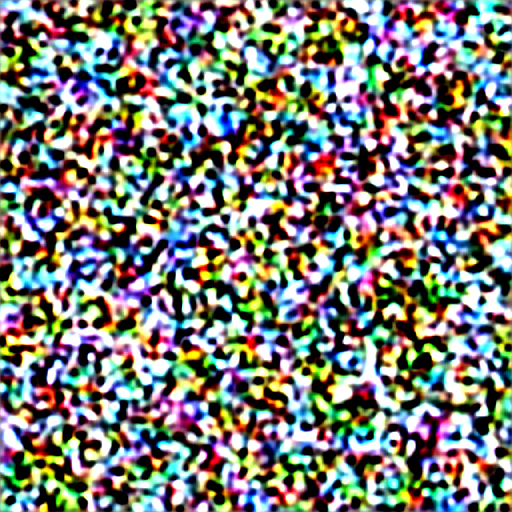

Step 2/70 Latents Norm: 1582.0
Step 3/70 Latents Norm: 1455.0
Step 4/70 Latents Norm: 1342.0
Step 5/70 Latents Norm: 1239.0
Step 6/70 Latents Norm: 1146.0
Step 7/70 Latents Norm: 1062.0
Step 8/70 Latents Norm: 986.5
Step 9/70 Latents Norm: 917.0
Step 10/70 Latents Norm: 854.5
Step 11/70 Latents Norm: 797.0
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])


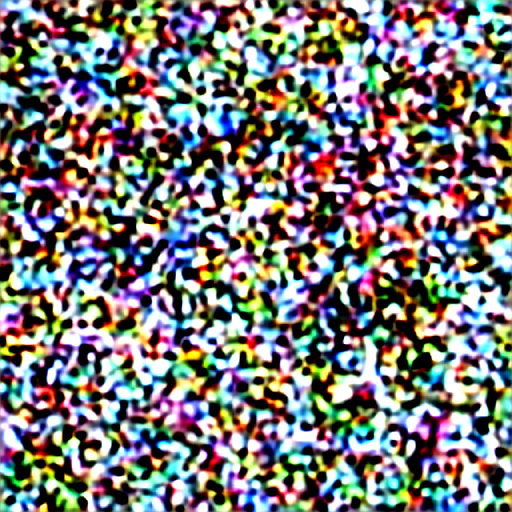

Step 12/70 Latents Norm: 745.0
Step 13/70 Latents Norm: 697.5
Step 14/70 Latents Norm: 654.0
Step 15/70 Latents Norm: 614.0
Step 16/70 Latents Norm: 577.5
Step 17/70 Latents Norm: 543.5
Step 18/70 Latents Norm: 512.5
Step 19/70 Latents Norm: 484.25
Step 20/70 Latents Norm: 458.25
Step 21/70 Latents Norm: 434.25
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])


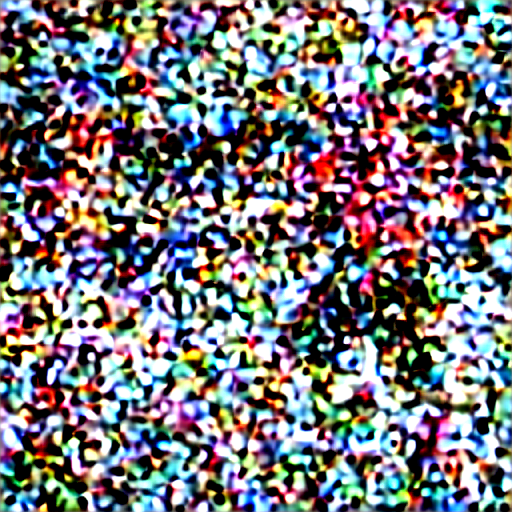

Step 22/70 Latents Norm: 412.0
Step 23/70 Latents Norm: 391.5
Step 24/70 Latents Norm: 372.5
Step 25/70 Latents Norm: 355.0
Step 26/70 Latents Norm: 338.75
Step 27/70 Latents Norm: 323.75
Step 28/70 Latents Norm: 309.5
Step 29/70 Latents Norm: 296.5
Step 30/70 Latents Norm: 284.25
Step 31/70 Latents Norm: 273.0
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])


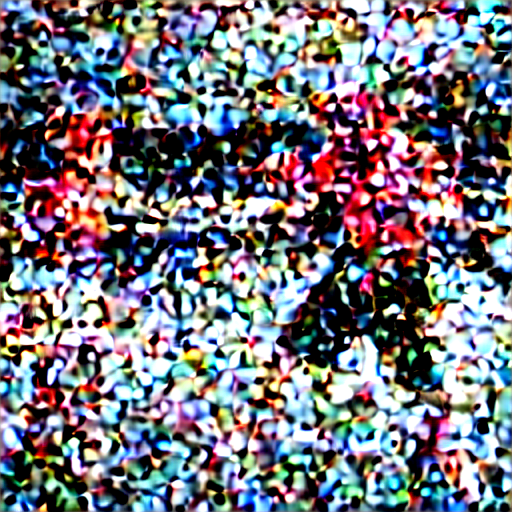

Step 32/70 Latents Norm: 262.5
Step 33/70 Latents Norm: 252.75
Step 34/70 Latents Norm: 243.625
Step 35/70 Latents Norm: 235.0
Step 36/70 Latents Norm: 227.0
Step 37/70 Latents Norm: 219.5
Step 38/70 Latents Norm: 212.5
Step 39/70 Latents Norm: 205.875
Step 40/70 Latents Norm: 199.75
Step 41/70 Latents Norm: 193.875
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])


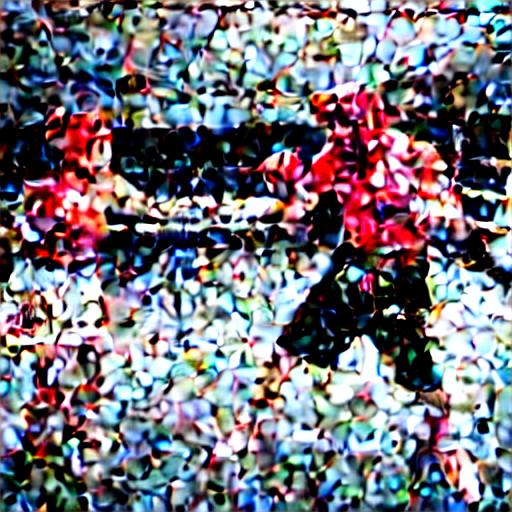

Step 42/70 Latents Norm: 188.5
Step 43/70 Latents Norm: 183.375
Step 44/70 Latents Norm: 178.625
Step 45/70 Latents Norm: 174.125
Step 46/70 Latents Norm: 169.875
Step 47/70 Latents Norm: 165.875
Step 48/70 Latents Norm: 162.25
Step 49/70 Latents Norm: 158.75
Step 50/70 Latents Norm: 155.375
Step 51/70 Latents Norm: 152.25
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])


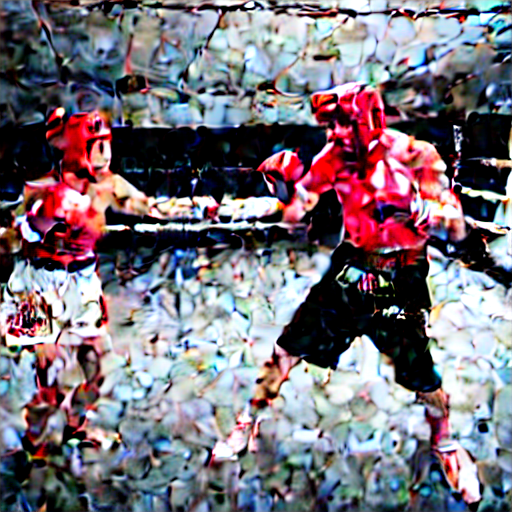

Step 52/70 Latents Norm: 149.375
Step 53/70 Latents Norm: 146.625
Step 54/70 Latents Norm: 144.125
Step 55/70 Latents Norm: 141.75
Step 56/70 Latents Norm: 139.5
Step 57/70 Latents Norm: 137.375
Step 58/70 Latents Norm: 135.375
Step 59/70 Latents Norm: 133.5
Step 60/70 Latents Norm: 131.75
Step 61/70 Latents Norm: 130.125
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])


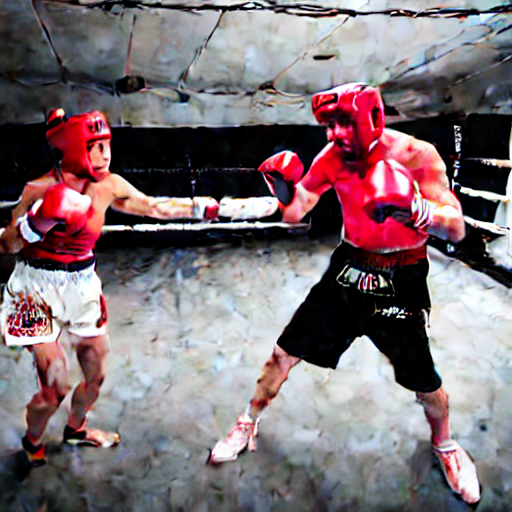

Step 62/70 Latents Norm: 128.625
Step 63/70 Latents Norm: 127.1875
Step 64/70 Latents Norm: 125.875
Step 65/70 Latents Norm: 124.625
Step 66/70 Latents Norm: 123.4375
Step 67/70 Latents Norm: 122.375
Step 68/70 Latents Norm: 121.4375
Step 69/70 Latents Norm: 120.5
Step 70/70 Latents Norm: 120.375
---- torch.Size([1, 4, 64, 64])
++++ torch.Size([1, 3, 512, 512])


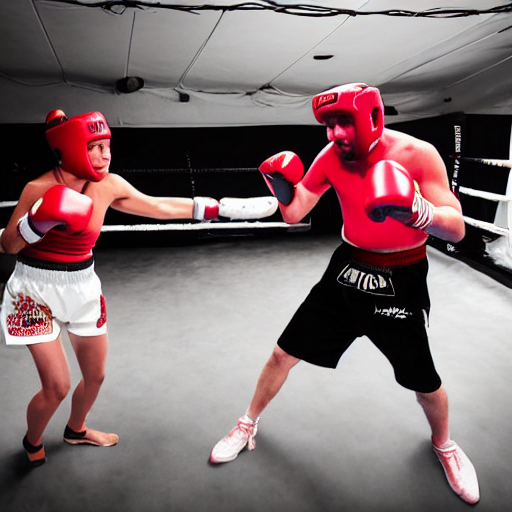

In [ ]:
import os
torch.cuda.empty_cache()

# Create the directory if it doesn't exist
os.makedirs("steps2", exist_ok=True)

# new_image = Image.open('dog 2.jpg').convert('RGB').resize((512,512))
# latents = pil_to_latents(new_image)

images = prompt_2_img(["Two people boxing"], save_int=True)
for img in images:display(img)